In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import re
import string
import spacy
import colorlover as cl
import random
import shap

from wordcloud import WordCloud
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from collections import Counter
from plotly.subplots import make_subplots
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import TreebankWordTokenizer as twt
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import TweetTokenizer as twt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vandavilli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/vandavilli/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/vandavilli/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
def process_load_data(dataframes):
    data = pd.concat(dataframes, ignore_index=True)

    # Select columns to be retained and rename them
    selected_columns = [
        'id',
        'context',
        'annotations/0/events/0/event_type',
        'annotations/0/events/0/Trigger/text/0/0',
        'annotations/0/events/0/Treatment/Drug/text/0/0',
        'annotations/0/events/0/Effect/text/0/0'
    ]
    new_names = ['id', 'context', 'event_type', 'trigger_text', 'drug', 'drug_effect']
    df = data[selected_columns].rename(columns=dict(zip(selected_columns, new_names)))

    # Map sentiment labels to numeric values
    sentiment_mapping = {'Adverse_event': 1, 'Potential_therapeutic_event': 0}
    df['sentiment'] = df['event_type'].map(sentiment_mapping)

    return df

In [4]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
dev_data = pd.read_csv('data/dev.csv')

dataframes = [train_data, test_data, dev_data]
df = process_load_data(dataframes)

Columns (112,114,121,125,157,168,186,188,206,208,217,229,231,232,233,235,237,241,244,246,247,249,250,251,268,270,271,280,282,286,288,289,291,305,310,312,313,315,316,318,319,323,324,327,328,329,331,333,335,336,338,342,344,348,350,352,353,355,356,358,359,361) have mixed types. Specify dtype option on import or set low_memory=False.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4827 entries, 0 to 4826
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            4827 non-null   object
 1   context       4827 non-null   object
 2   event_type    4827 non-null   object
 3   trigger_text  4827 non-null   object
 4   drug          4780 non-null   object
 5   drug_effect   4472 non-null   object
 6   sentiment     4827 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 264.1+ KB


#### Analyze adverse events and potential therapeutic events, count their occurrences, and identify drugs with both positive and negative impacts.

In [6]:
# Filter for ADE and PTE
adverse_events_df = df[df['event_type'] == 'Adverse_event']
potential_therapeutic_events_df = df[df['event_type'] == 'Potential_therapeutic_event']

# Group by drug and drug_effect, and count the occurrences separately for ADE and PTE
adverse_cooccurrence_df = adverse_events_df.groupby(['drug', 'drug_effect']).size().reset_index(name='ADE')
potential_therapeutic_cooccurrence_df = potential_therapeutic_events_df.groupby(
    ['drug', 'drug_effect']).size().reset_index(name='PTE')

cooccurrence_merged_df = pd.merge(adverse_cooccurrence_df, potential_therapeutic_cooccurrence_df, 
                                  on='drug', how='outer')

# Filter for drugs with both ADE and PTE
cooccurrences_df = cooccurrence_merged_df[cooccurrence_merged_df['ADE'].notnull() & 
                                          cooccurrence_merged_df['PTE'].notnull()]

cooccurrences_df = cooccurrences_df.copy()

In [7]:
cooccurrences_df.sample(10)

,drug,drug_effect_x,ADE,drug_effect_y,PTE
3014,olanzapine,Priapism,1.0,without the risk of recurrence of hematologic ...,1.0
2768,methotrexate,presenting with status epilepticus,1.0,regressed,1.0
4094,zonisamide,Heat stroke-like episode,1.0,regained the ability to sweat within 2 weeks,1.0
2748,methotrexate,diffuse pruritic papular eruption located main...,1.0,regressed,1.0
3199,phenytoin,Fever and maculopapular rashes,1.0,seizures,1.0
3321,propranolol,bronchospasm,2.0,central nervous system effects,1.0
4,2-CdA,a long-lasting state of immunodeficiency,1.0,durable complete remission,1.0
3326,propranolol,esophageal spasm preventing extrication of an ...,1.0,central nervous system effects,1.0
3367,pyridoxine,acute hypotonia,1.0,recovery of vincristine induced cranial polyne...,1.0
2732,methotrexate,an intracranial mass lesion,1.0,regressed,1.0


In [8]:
ade_or_pte_values = cooccurrence_merged_df[(cooccurrence_merged_df['ADE'] > 1) | 
                                           (cooccurrence_merged_df['PTE'] > 1)]
ade_or_pte_df = df[df['drug'].isin(ade_or_pte_values['drug'])]

In [9]:
ade_or_pte_df.sample(5)

,id,context,event_type,trigger_text,drug,drug_effect,sentiment
4170,9925865_3,Lipoid pneumonia: a silent complication of min...,Adverse_event,of,mineral oil,Lipoid pneumonia,1
1694,3379435_3,Three senile patients developed fatal acute en...,Adverse_event,developed,calcium hopantenate,encephalopathy,1
2424,11197768_3,"The toxicity of cadmium, zinc, and cadmium/zin...",Adverse_event,of,cadmium,toxicity,1
3820,18855892_2,Anaphylactic/anaphylactoid reactions to methot...,Adverse_event,to,methotrexate,Anaphylactic/anaphylactoid reactions,1
1225,8071504_1,Toxic optic neuropathy associated with ethambu...,Adverse_event,associated,ethambutol,Toxic optic neuropathy,1


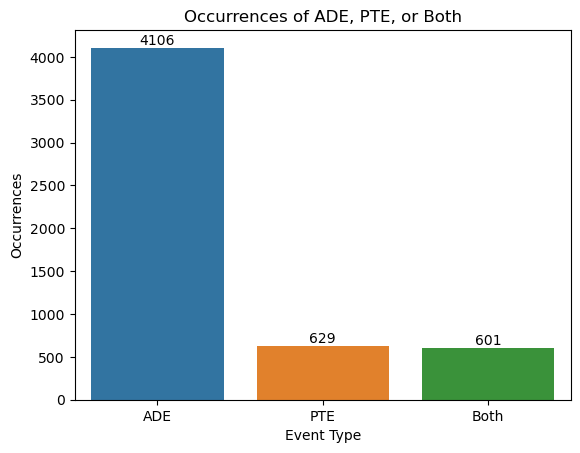

In [10]:
# Filter for ADE, PTE, or both
ade_df = cooccurrence_merged_df[cooccurrence_merged_df['ADE'].notnull()]
pte_df = cooccurrence_merged_df[cooccurrence_merged_df['PTE'].notnull()]

# Count the occurrences for ADE and PTE
ade_count = len(ade_df)
pte_count = len(pte_df)
both_count = len(cooccurrences_df)

# Create a bar plot using Seaborn
event_types = ['ADE', 'PTE', 'Both']
occurrence_counts = [ade_count, pte_count, both_count]

# Create the bar plot
ax = sns.barplot(x=event_types, y=occurrence_counts)
plt.xlabel('Event Type')
plt.ylabel('Occurrences')
plt.title('Occurrences of ADE, PTE, or Both')

# Display the counts on each bar
for i, count in enumerate(occurrence_counts):
    ax.text(i, count, str(count), ha='center', va='bottom')

plt.show()

In [11]:
#These words don't add any value or sentiment in the world of pharmacovigilance. 
#Hence removing them along with sample english stop words
pharmaco_vigil_stopwords = [
    'patient', 'patients', 'event', 'drug', 'medication', 'treatment',
    'symptoms', 'dose', 'dosage', 'safety', 'efficacy', 'monitoring',
    'pharmacovigilance', 'reporting', 'healthcare', 'study', 'trial', 'outcome',
    'population', 'exposure', 'protocol', 'review', 'analysis', 'information',
    'evaluation', 'surveillance', 'benefit', 'assessment', 'labeling', 'label',
    'labelled', 'unlabelled', 'off-label', 'contraindications', 'contraindicated',
    'interaction', 'interactions', 'concomitant', 'co-administration', 'indications',
    'precaution', 'precautions', 'administration', 'route', 'dosage', 'pharmacokinetics',
    'pharmacodynamics', 'absorption', 'distribution', 'metabolism', 'elimination',
    'bioavailability', 'half-life', 'clearance', 'efficiency', 'effectiveness', 'monitor',
    'monitoring', 'protocol', 'endpoint', 'protocol', 'standard', 'randomization',
    'randomized', 'controlled', 'placebo', 'baseline', 'efficacy', 'primary',
    'secondary', 'endpoint', 'conclusion', 'summary', 'analysis', 'study', 'result',
    'results', 'data', 'analysis', 'statistics', 'significant', 'p-value',
    'confidence', 'interval', 'review', 'systematic', 'meta-analysis', 'literature',
    'case', 'series', 'report', 'summary', 'benefit-risk', 'balance', 'advice',
    'recommendation', 'guideline', 'guidelines', 'regulatory', 'agency',
    'pharmaceutical', 'company', 'manufacturer', 'labeling', 'product', 'package',
    'insert', 'leaflet', 'contraindication', 'interaction', 'overdose', 'warning',
    'precaution', 'adverse', 'event', 'reaction', 'pregnancy', 'lactation',
    'pediatric', 'geriatric', 'elderly', 'population', 'patient', 'population',
    'drug', 'abuse', 'dependence', 'misuse', 'off-label', 'off-label', 'use',
    'contraindicated', 'indications', 'symptom', 'symptoms', 'sign', 'signs',
    'syndrome', 'syndromes', 'syndromic', 'hypersensitivity', 'intolerance',
    'overdose', 'overdoses', 'toxicity', 'dose', 'doses', 'exposure', 'exposures',
    'administration', 'route', 'routes', 'schedule', 'schedules', 'interval',
    'intervals', 'pharmacokinetics', 'pharmacokinetic', 'pharmacodynamics',
    'pharmacodynamic', 'metabolism', 'metabolic', 'elimination', 'eliminations',
    'half-life', 'clearance', 'efficiency', 'effectiveness', 'monitor'
]

In [12]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s-]', '', text)
    text = re.sub(r'[^a-zA-Z\s-]', '', text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    tokens = text.split()
    stop_words = set(stopwords.words('english')).union(pharmaco_vigil_stopwords)
    tokens = [token for token in tokens if token not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    cleaned_text = ' '.join(tokens)
    return cleaned_text


def get_most_common_words(df):
    stop = set(stopwords.words("english")).union(pharmaco_vigil_stopwords)
    corpus = [word for text in df["context_clean"] for word in word_tokenize(text) if word not in stop]
    most_common = Counter(corpus).most_common(10)
    words, frequency = zip(*most_common)
    return words, frequency

def get_ngram_freq(n, df):
    stop = set(stopwords.words("english")).union(pharmaco_vigil_stopwords)
    vec = CountVectorizer(stop_words=stop, ngram_range=(n, n))
    bow = vec.fit_transform(df["context_clean"])
    count_values = bow.toarray().sum(axis=0)
    ngram_freq = pd.DataFrame(zip(count_values, vec.get_feature_names()), columns=["frequency", "ngram"])
    ngram_freq.sort_values(by="frequency", ascending=False, inplace=True)
    return ngram_freq

In [13]:
df["char_count"] = df["context"].str.len()
df["word_count"] = df["context"].apply(lambda x: len(x.split()))
df["sent_count"] = df["context"].apply(lambda x: len(sent_tokenize(x)))
df["avg_word_len"] = df["context"].apply(lambda x: np.mean([len(w) for w in x.split()]))
df["avg_sent_len"] = df["context"].apply(lambda x: np.mean([len(w.split()) for w in sent_tokenize(x)]))
df["context_clean"] = df["context"].apply(preprocess_text)

#### The `analyze_rare_words` function is designed for pharmacovigilance analysis to identify and analyze rare words in text data. It helps in signal detection, data quality control, safety monitoring, pattern analysis, and enhancing pharmacovigilance reporting by providing insights into rare events and adverse drug reactions.

In [14]:
def analyze_rare_words(df, column_name, top_k=5, threshold=5):
    rare_words_rows = []
    for index, row in df.iterrows():
        words = word_tokenize(row[column_name])
        word_counts = Counter(words)
        rare_words = [word for word, count in word_counts.items() if count <= threshold]
        rare_words = sorted(rare_words, key=lambda x: word_counts[x], reverse=True)
        if rare_words:
            rare_words_rows.append(' '.join(rare_words))
        else:
            rare_words_rows.append('')
    
    df['rare_words'] = rare_words_rows[:len(df)]
    return df

In [15]:
df = analyze_rare_words(df, "context_clean", top_k=10, threshold=5)

In [16]:
df["rare_words"]

0       objective test hypothesis tumor necrosis facto...
1       ovarian structure function considered woman re...
2            phenobarbital hepatotoxicity monthold infant
3       author balint irreversible posterior leukoence...
4       probability scale flecainide according naranjo...
                              ...                        
4822    successful challenge clozapine history eosinop...
4823    pancreatitis yearold female cardiomyopathy sul...
4824    acute intravascular hemolysis developed diabet...
4825    intravitreal triamcinolone may influence exace...
4826    evaluated developed psychotic disorder month i...
Name: rare_words, Length: 4827, dtype: object

In [17]:
df.describe()

,sentiment,char_count,word_count,sent_count,avg_word_len,avg_sent_len
count,4827.000000,4827.000000,4827.000000,4827.000000,4827.000000,4827.000000
mean,0.906567,135.418272,18.498032,1.004558,6.755781,18.434742
std,0.291068,61.446520,9.241148,0.067364,1.511272,9.178977
min,0.000000,19.000000,2.000000,1.000000,3.647059,2.000000
25%,1.000000,90.000000,12.000000,1.000000,5.857143,12.000000
50%,1.000000,126.000000,17.000000,1.000000,6.428571,17.000000
75%,1.000000,171.000000,24.000000,1.000000,7.233032,24.000000
max,1.000000,527.000000,75.000000,2.000000,20.000000,75.000000


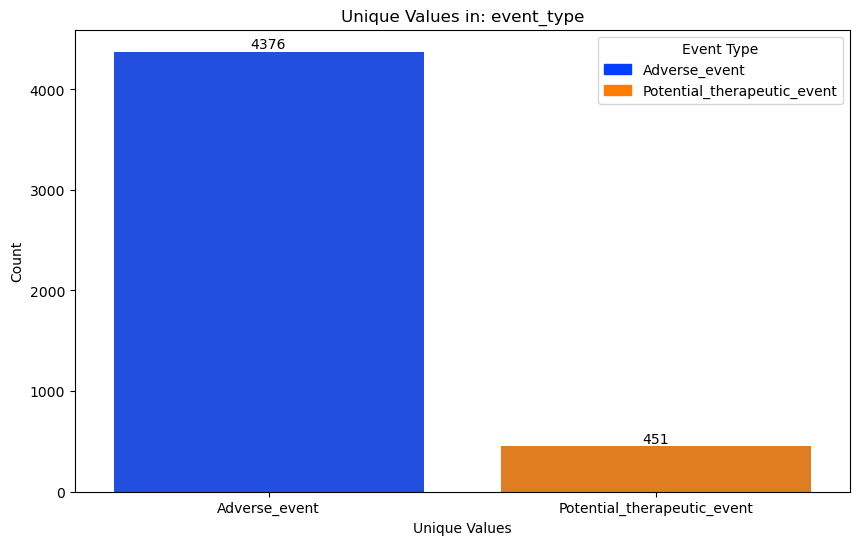

In [18]:
selected_column = 'event_type'

unique_values = df[selected_column].value_counts()
color_palette = sns.color_palette('bright', n_colors=len(unique_values))

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=unique_values.index, y=unique_values.values, palette=color_palette)

for i, value in enumerate(unique_values.values):
    ax.annotate(value, (i, value), ha='center', va='bottom', fontsize=10)

plt.title(f'Unique Values in: {selected_column}')
plt.xlabel('Unique Values')
plt.ylabel('Count')

handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in color_palette]
labels = unique_values.index
plt.legend(handles, labels, title='Event Type', loc='upper right')

plt.show()

#### The KDE plot summary is as follows:

In the context of a pharmacovigilance sentiment analysis dataset, the summary of the KDE plot results suggests the following:

- Sentiment: The dataset primarily consists of data points with a negative sentiment (sentiment value of 1), indicating that most of the sentiments expressed towards the pharmacovigilance topics are negative. However, there is a smaller portion of data points with a positive sentiment (sentiment value of 0), indicating the presence of positive sentiments in the dataset as well.

- Character Count: The character count distribution suggests that the length of text varies, ranging from 19 to 527 characters. The moderate spread and presence of outliers indicate that there is variation in the length of the text data in the dataset.

- Word Count: The word count distribution indicates that the number of words used in the text ranges from 2 to 75. The moderate right-skewness suggests that most of the texts have a moderate word count, but there are also texts with a higher word count.

- Sentence Count: The dataset primarily consists of text data with a single sentence (sentence count of 1), indicating that most of the sentiments expressed are contained within a single sentence. The small standard deviation suggests consistency in sentence structure across the dataset.

- Average Word Length: The average word length is approximately 6.75 characters. This information provides an insight into the average length of individual words used in the dataset. It can be helpful in understanding the linguistic patterns and complexity of the sentiments expressed.

- Average Sentence Length: The average sentence length is approximately 18 words. The moderate right-skewness suggests that while most sentences have a moderate length, there are also longer sentences present in the dataset. 

All these counts imply that sentiments in pharmacovigilance texts are expressed using sentences of varying lengths, which can provide more detailed and nuanced information. What this means is, despite a high accuracy, a human intervention is also needed before a drug is dispensed. 

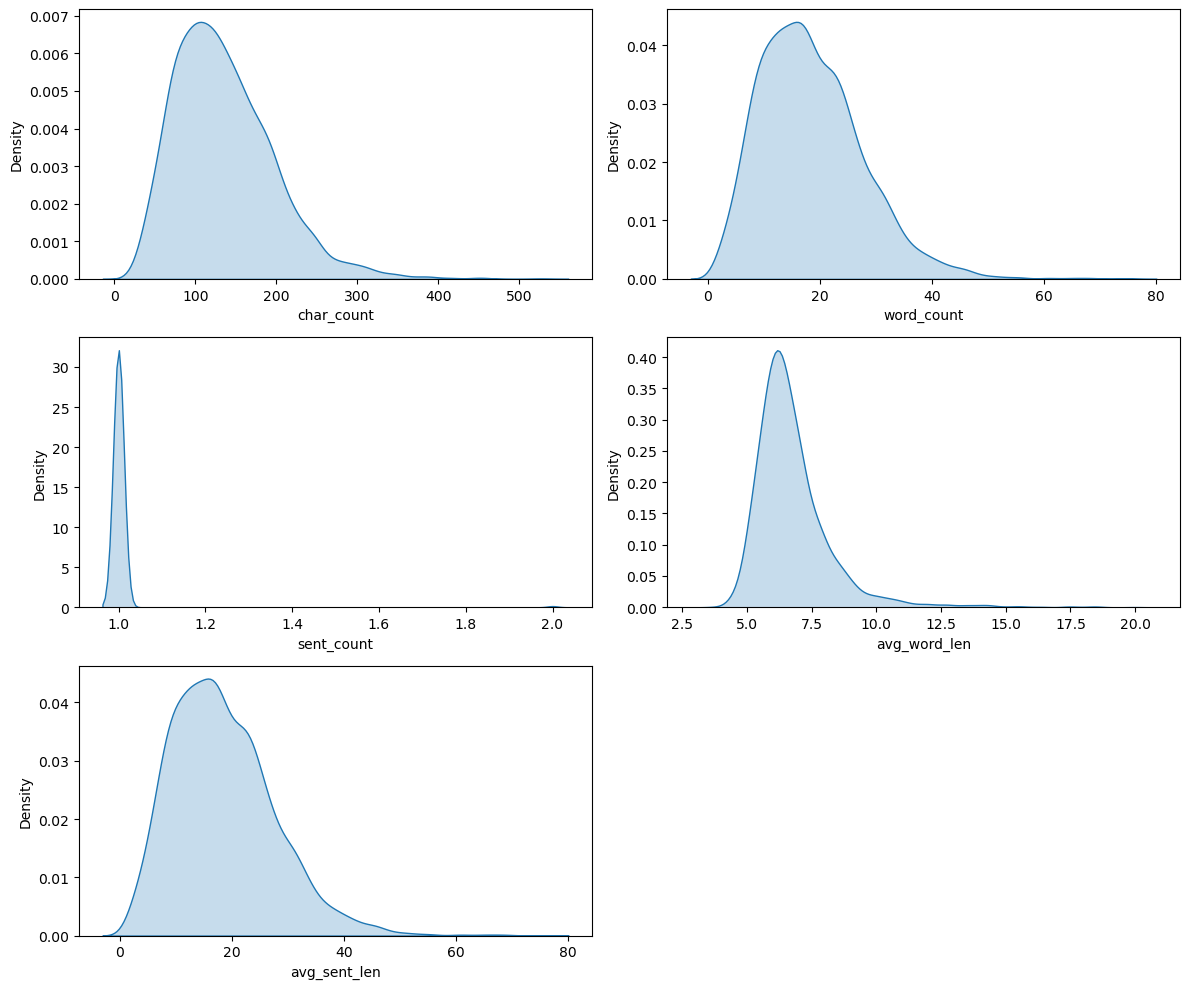

In [19]:
num_columns = 2
num_rows = 3

fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 10))
axes = axes.ravel()

interesting_columns = ['char_count', 'word_count', 'sent_count', 'avg_word_len', 'avg_sent_len']

# Generate KDE subplots for each column
for i, column in enumerate(interesting_columns[:5]):
    sns.kdeplot(data=df[column], shade=True, ax=axes[i])
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Density')

# Remove the last subplot if there is an odd number of columns
if len(interesting_columns) % 2 != 0:
    fig.delaxes(axes[-1])

# Adjust spacing and display the subplots
plt.tight_layout()
plt.show()

In [20]:
def create_corpus(df, column_name):
    stop = set(stopwords.words("english") + pharmaco_vigil_stopwords)
    corpus = [word for i in df[column_name].str.split().values.tolist() for word in i if word not in stop]
    return corpus

In [21]:
corpus = create_corpus(df, "context_clean")

<AxesSubplot:>

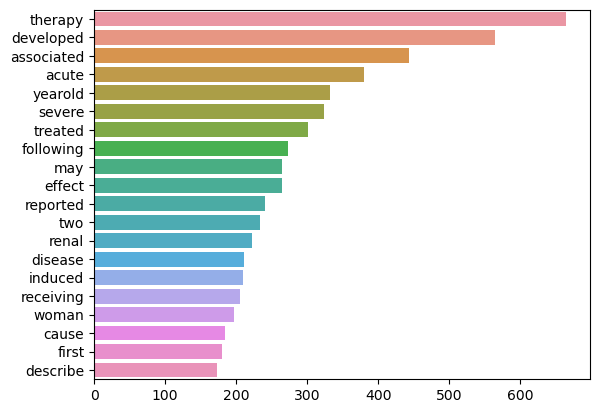

In [22]:
most_common = Counter(corpus).most_common(20)

words, frequency = [], []
for word, count in most_common:
    words.append(word)
    frequency.append(count)
    
sns.barplot(x = frequency, y = words)

In [23]:
positive_event_to_match = 'Potential_therapeutic_event'
positive_df = df[df['event_type'] == positive_event_to_match]
positive_corpus = create_corpus(positive_df, "context_clean")

<AxesSubplot:>

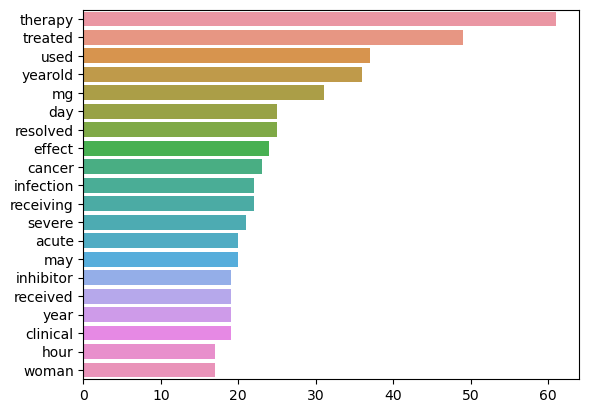

In [24]:
common_pos_words = Counter(positive_corpus).most_common(20)

words, frequency = [], []
for word, count in common_pos_words:
    words.append(word)
    frequency.append(count)
    
sns.barplot(x = frequency, y = words)

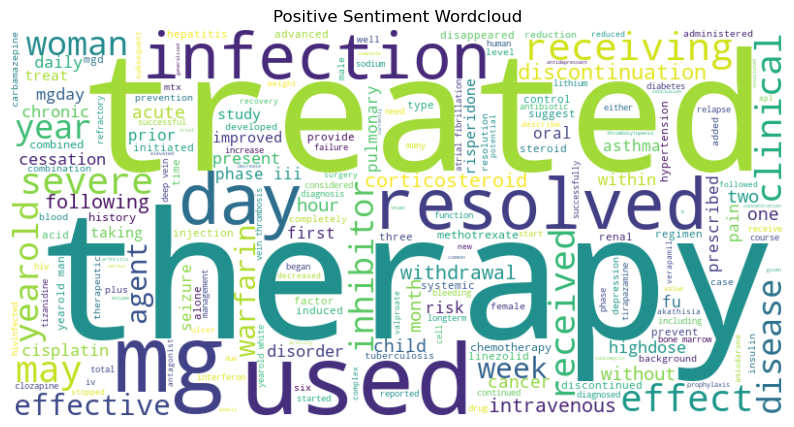

In [25]:
# Postive sentiment word cloud
text = ' '.join(positive_df['context_clean'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Sentiment Wordcloud')
plt.show()

In [26]:
negative_event_to_match = 'Adverse_event'
negative_df = df[df['event_type'] == negative_event_to_match]
negative_corpus = create_corpus(negative_df, "context_clean")

In [27]:
negative_df[0:5]

,id,context,event_type,trigger_text,drug,drug_effect,sentiment,char_count,word_count,sent_count,avg_word_len,avg_sent_len,context_clean,rare_words
0,8908396_3,OBJECTIVE: To test the hypothesis that tumor n...,Adverse_event,induced,insulin,lipoatrophies,1,238,33,1,6.242424,33.0,objective test hypothesis tumor necrosis facto...,objective test hypothesis tumor necrosis facto...
1,10891991_1,An evaluation of ovarian structure and functio...,Adverse_event,develop,valproate,menstrual cycle disturbances,1,214,30,1,6.166667,30.0,ovarian structure function considered woman re...,ovarian structure function considered woman re...
2,2332596_1,Phenobarbital hepatotoxicity in an 8-month-old...,Adverse_event,in,Phenobarbital,hepatotoxicity,1,54,6,1,8.166667,6.0,phenobarbital hepatotoxicity monthold infant,phenobarbital hepatotoxicity monthold infant
3,12552054_1,The authors report a case of Balint syndrome w...,Adverse_event,following,methotrexate,Balint syndrome with irreversible posterior le...,1,150,19,1,6.947368,19.0,author balint irreversible posterior leukoence...,author balint irreversible posterior leukoence...
4,19531695_12,"According to the Naranjo probability scale, fl...",Adverse_event,cause,flecainide,delirium,1,237,31,1,6.677419,31.0,according naranjo probability scale flecainide...,probability scale flecainide according naranjo...


<AxesSubplot:>

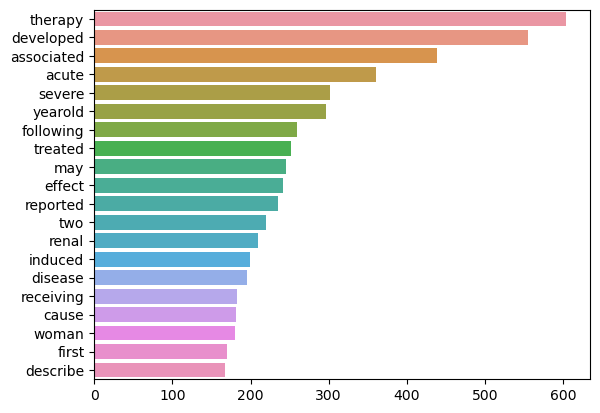

In [28]:
common_negative_words = Counter(negative_corpus).most_common(20)

words, frequency = [], []
for word, count in common_negative_words:
    words.append(word)
    frequency.append(count)
    
sns.barplot(x = frequency, y = words)

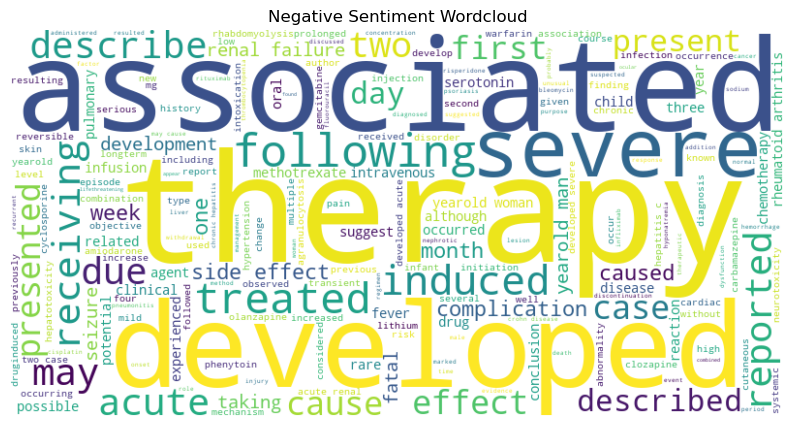

In [29]:
# Negative sentiment word cloud
text = ' '.join(negative_df['context_clean'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Sentiment Wordcloud')
plt.show()

### Unveiling Insights: Leveraging Data Analysis for Actionable Pharmacovigilance Intelligence

- Sentiment Distribution: The dataset mainly consists of negative sentiments, indicating a higher prevalence of reporting adverse events and negative experiences related to therapies or medications.

- Imbalance in Sentiment: There is an imbalance in sentiment distribution, with a greater focus on negative outcomes and adverse effects, highlighting the need to address potential risks and safety concerns.

- Importance of Negative Mention Detection: The prominence of common negative words emphasizes the importance of effectively detecting and analyzing negative mentions in pharmacovigilance to identify and mitigate potential risks.

- Scope for Positive Sentiment Exploration: There is potential for further exploration of positive sentiments within the dataset, which can provide insights into successful treatment outcomes and favorable patient responses.

This summary report highlights the need to carefully analyze sentiment distribution, address potential risks, and explore positive sentiments for comprehensive pharmacovigilance insights.

In [30]:
def visualize_rare_words(dataframe, column_name, top_k=20):
    combined_text = ' '.join(dataframe[column_name].apply(lambda x: ' '.join(x)).astype(str))
    words = combined_text.split()

    words = [word for word in words if word not in string.punctuation]

    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    word_counts = pd.Series(words).value_counts().head(top_k).reset_index()
    word_counts.columns = ['Word', 'Frequency']

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=word_counts, x='Word', y='Frequency', size='Frequency', hue='Frequency',
                    sizes=(50, 500), palette='Blues', legend=True)
    plt.xlabel('Rare Words')
    plt.ylabel('Frequency')
    plt.title('Top 20 Rare Words')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

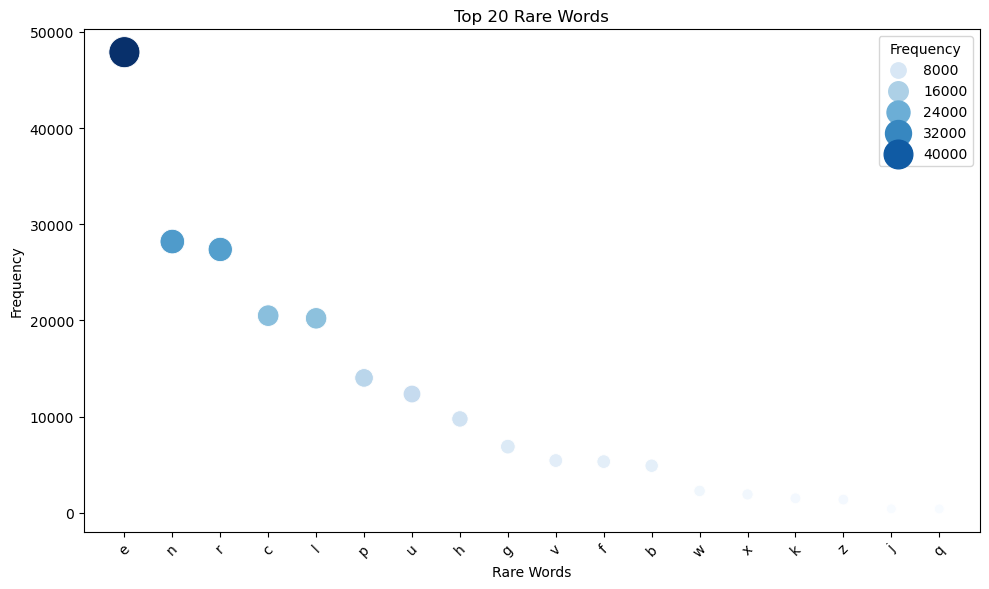

In [31]:
visualize_rare_words(df, 'rare_words', top_k=20)

In [32]:
def extract_top_ngrams(df, column_name, n_gram_range, top_n):
    vectorizer = CountVectorizer(ngram_range=n_gram_range)
    X = vectorizer.fit_transform(df[column_name])
    feature_names = vectorizer.get_feature_names_out()
    ngram_counts = X.sum(axis=0)
    sorted_ngrams = sorted([(count, ngram) for ngram, count in zip(feature_names, ngram_counts.tolist()[0])], 
                           reverse=True)
    
    result_df = pd.DataFrame(sorted_ngrams[:top_n], columns=['Frequency', 'N-gram'])
    return result_df

In [33]:
top_ngrams_df = extract_top_ngrams(df, 'context_clean', n_gram_range=(2, 4), top_n=10)

In [34]:
top_neg_ngrams_df = extract_top_ngrams(negative_df, 'context_clean', n_gram_range=(2, 4), top_n=10)

In [35]:
top_pos_ngrams_df = extract_top_ngrams(positive_df, 'context_clean', n_gram_range=(2, 4), top_n=10)

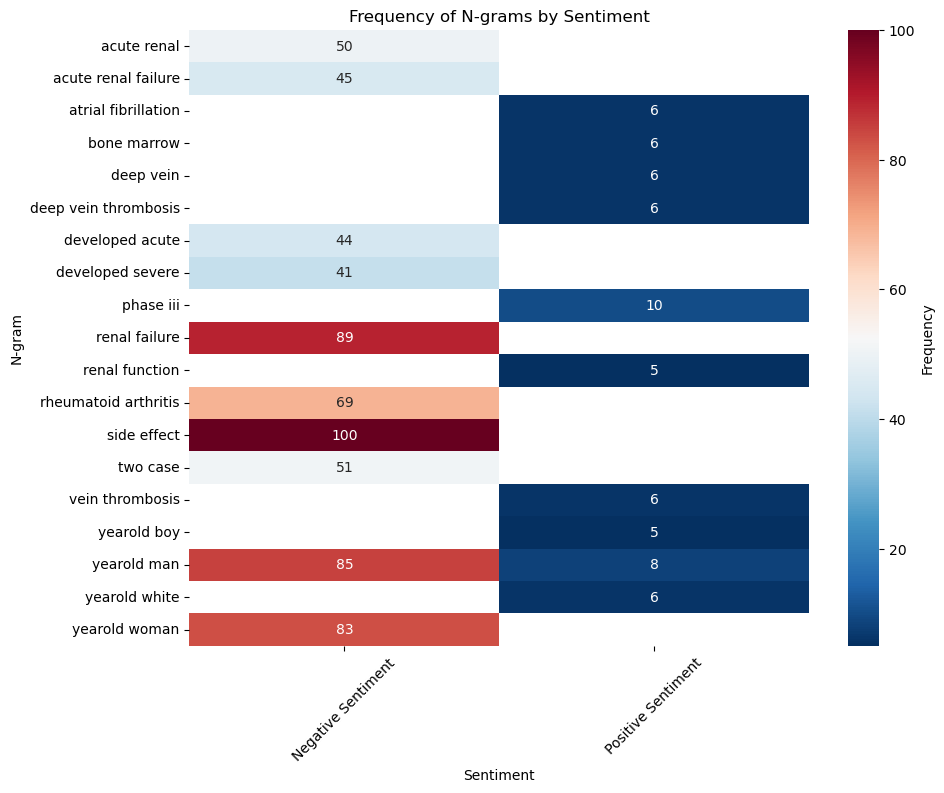

In [36]:
top_ngrams_df['Sentiment'] = 'Overall'
top_neg_ngrams_df['Sentiment'] = 'Negative'
top_pos_ngrams_df['Sentiment'] = 'Positive'

combined_df = pd.concat([top_neg_ngrams_df, top_pos_ngrams_df], ignore_index=True)
sentiment_labels = {'Negative': 'Negative Sentiment', 'Positive': 'Positive Sentiment'}

combined_df['Sentiment'] = combined_df['Sentiment'].map(sentiment_labels)

heatmap_data = combined_df.pivot(index='N-gram', columns='Sentiment', values='Frequency')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='RdBu_r', cbar=True, cbar_kws={'label': 'Frequency'})

# Set labels and title
plt.xlabel('Sentiment')
plt.ylabel('N-gram')
plt.title('Frequency of N-grams by Sentiment')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

### Conclusion: Analysis of the extracted n-grams
- Common n-grams in both positive and negative contexts: "side effect" and "renal failure" indicate recurring topics in reviews.
- Negative n-grams: "yearold man/woman" suggest age-related concerns, while "rheumatoid arthritis" and "acute renal failure" highlight challenges in managing these conditions.
- Positive n-grams: "phase III" indicates positive sentiment towards advanced clinical trials, while "bone marrow" and "atrial fibrillation" suggest positive experiences in related treatments.

The heatmap data showcases the frequency of N-grams across negative and positive sentiments, highlighting the prevalent terms and phrases associated with each sentiment category. These insights help identify recurring themes and important aspects in sentiment analysis of the dataset.

In [37]:
def pos_analysis(df, column_name):
    nltk.download('punkt')
    nltk.download('averaged_perceptron_tagger')

    result_df = pd.DataFrame({'text': df[column_name],
                              'tokens': df[column_name].apply(word_tokenize),
                              'pos_tags': df[column_name].apply(lambda x: pos_tag(word_tokenize(x)))
                             })

    adjectives = []
    adverbs = []
    nouns = []
    verbs = []

    for i, pos_tags in enumerate(result_df['pos_tags']):
        adj = []
        adv = []
        noun = []
        verb = []
        for word, tag in pos_tags:
            if tag.startswith('JJ'):  # Adjective
                adj.append(word)
            elif tag.startswith('RB'):  # Adverb
                adv.append(word)
            elif tag.startswith('NN'):  # Noun
                noun.append(word)
            elif tag.startswith('VB'):  # Verb
                verb.append(word)
        adjectives.append(adj)
        adverbs.append(adv)
        nouns.append(noun)
        verbs.append(verb)

    result_df['adjectives'] = adjectives
    result_df['adverbs'] = adverbs
    result_df['nouns'] = nouns
    result_df['verbs'] = verbs

    return result_df

In [38]:
column_name = 'context_clean'

In [39]:
negative_pos_df = pos_analysis(negative_df, column_name)
positive_pos_df = pos_analysis(positive_df, column_name)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vandavilli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/vandavilli/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vandavilli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/vandavilli/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [40]:
negative_pos_df.sample(5)

,text,tokens,pos_tags,adjectives,adverbs,nouns,verbs
1590,present yrold male developed severe nephrotic ...,"[present, yrold, male, developed, severe, neph...","[(present, JJ), (yrold, RB), (male, NN), (deve...","[present, severe, nephrotic, multiple, weekly]",[yrold],"[male, sclerosis, rrms, injection, interferon,...","[developed, treated, relapsingremitting]"
2560,flurbiprofenassociated acute tubulointerstitia...,"[flurbiprofenassociated, acute, tubulointersti...","[(flurbiprofenassociated, VBN), (acute, JJ), (...","[acute, tubulointerstitial]",[],[nephritis],[flurbiprofenassociated]
4602,cerebral edema associated gliadel wafer two study,"[cerebral, edema, associated, gliadel, wafer, ...","[(cerebral, JJ), (edema, NN), (associated, VBN...",[cerebral],[],"[edema, gliadel, wafer, study]",[associated]
453,infectious mononucleosis treated cephalexin la...,"[infectious, mononucleosis, treated, cephalexi...","[(infectious, JJ), (mononucleosis, NN), (treat...","[infectious, previous]",[later],"[mononucleosis, cephalexin, rash, reviewed]","[treated, showed, presented]"
1411,recurrent increasingly severe episode ppe ulti...,"[recurrent, increasingly, severe, episode, ppe...","[(recurrent, NN), (increasingly, RB), (severe,...","[severe, bullous, successive, highdose, lympho...","[increasingly, ultimately, severe]","[recurrent, episode, ppe, eruption, cycle, cyt...","[complicated, following]"


In [41]:
positive_pos_df.sample(5)

,text,tokens,pos_tags,adjectives,adverbs,nouns,verbs
3861,yearold man receiving longterm anticoagulation...,"[yearold, man, receiving, longterm, anticoagul...","[(yearold, JJ), (man, NN), (receiving, VBG), (...","[yearold, longterm, total, weekly, monthly]",[],"[man, anticoagulation, warfarin, sodium, mg, a...","[receiving, arrived]"
1207,platinumresistant ovarian cancer proc constitu...,"[platinumresistant, ovarian, cancer, proc, con...","[(platinumresistant, JJ), (ovarian, JJ), (canc...","[platinumresistant, ovarian, therapeutic, trad...",[],"[cancer, proc, dilemma, cytotoxic, agent]","[constitutes, limited]"
4246,amphotericin b nephrotoxicity human decreased ...,"[amphotericin, b, nephrotoxicity, human, decre...","[(amphotericin, NN), (b, NN), (nephrotoxicity,...",[],[],"[amphotericin, b, nephrotoxicity, human, salt,...",[decreased]
675,suggest esmolol dysrhythmias caffeine best kno...,"[suggest, esmolol, dysrhythmias, caffeine, bes...","[(suggest, JJS), (esmolol, NN), (dysrhythmias,...","[suggest, dysrhythmias, best, purpose]",[],"[esmolol, caffeine, knowledge, esmolol]",[reported]
2230,absence ideal doseintense fu monotherapy regim...,"[absence, ideal, doseintense, fu, monotherapy,...","[(absence, NN), (ideal, NN), (doseintense, NN)...","[monthly, lowdose, lv, simple, economical, col...",[],"[absence, ideal, doseintense, fu, monotherapy,...","[provides, achieve, advanced]"


In [42]:
def plot_pos_sentiment_analysis(df_positive, df_negative):
    # Calculate the frequency of each part of speech for positive DataFrame
    pos_freq_positive = {
        'Adjectives': df_positive['adjectives'].apply(len).sum(),
        'Adverbs': df_positive['adverbs'].apply(len).sum(),
        'Nouns': df_positive['nouns'].apply(len).sum(),
        'Verbs': df_positive['verbs'].apply(len).sum()
    }

    # Calculate the frequency of each part of speech for negative DataFrame
    pos_freq_negative = {
        'Adjectives': df_negative['adjectives'].apply(len).sum(),
        'Adverbs': df_negative['adverbs'].apply(len).sum(),
        'Nouns': df_negative['nouns'].apply(len).sum(),
        'Verbs': df_negative['verbs'].apply(len).sum()
    }

    # Create a DataFrame for positive and negative frequencies
    pos_freq_data = pd.DataFrame({
        'Part of Speech': list(pos_freq_positive.keys()),
        'Positive': list(pos_freq_positive.values()),
        'Negative': list(pos_freq_negative.values())
    })

    # Melt the DataFrame for easier plotting
    pos_freq_data_melted = pos_freq_data.melt('Part of Speech', var_name='Sentiment Type', value_name='Frequency')

    color_palette = ["#00FF00", "#FF0000"]
    
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=pos_freq_data_melted, x='Part of Speech', y='Frequency', 
                     hue='Sentiment Type', palette=color_palette)

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=10, color='black')
    
    plt.xlabel('Part of Speech')
    plt.ylabel('Frequency')
    plt.title('Parts of Speech by Sentiment Type')

    plt.show()

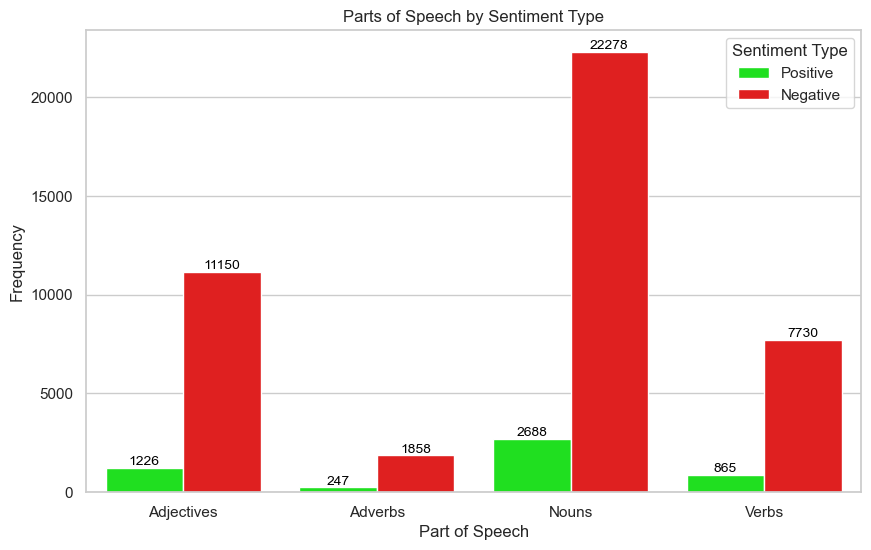

In [43]:
plot_pos_sentiment_analysis(positive_pos_df, negative_pos_df)

### Conclusion

In the context of pharmacovigilance, the visualization reveals the following patterns:

- Adjectives: Both positive and negative reports show a relatively low frequency of adjectives, indicating limited reliance on subjective descriptions or evaluations.

- Adverbs: Negative reports have a slightly higher count of adverbs compared to positive reports, suggesting greater emphasis on describing the intensity of adverse events.

- Nouns: Nouns have higher frequencies overall, with positive reports (overall) exhibiting a broader range of adverse events.

- Verbs: Verbs have the highest frequencies, particularly in positive reports, indicating active expression of drug effects or outcomes.

Overall, the visualization suggests that safety reports in pharmacovigilance often rely more on nouns and verbs to describe adverse events, while adjectives and adverbs play a lesser role. This highlights the importance of accurate and detailed reporting of specific adverse events and the associated actions or effects of drugs.